# Training Data without Cold Start 

In [1]:
import sys
import os

sys.path.append(os.path.abspath("../"))
import importlib
import data_processing  # Now you can import the module
importlib.reload(data_processing)


<module 'data_processing' from '/notebooks/ML-system-design/personalized-fashion-recommendations/data_processing.py'>

In [ ]:
customers, articles, transactions = data_processing.read_data(path="../data/")

In [ ]:
train, test = data_processing.train_test_no_coldstart(transactions, factor=1000)

In [ ]:
train.shape, test.shape

In [8]:
train_xs_ys, test_xs_ys = data_processing.get_labels_no_coldstart(train), data_processing.get_labels_no_coldstart(test)

In [9]:
# Ensure that test set only contains users and articles seen in training:
train_users = set(train_xs_ys["customer_id"].unique())
test_users  = set(test_xs_ys["customer_id"].unique())
print (len(train_users), len(test_users), test_users.issubset(train_users))

train_articles = set(train_xs_ys["article_id"].unique())
test_articles  = set(test_xs_ys["article_id"].unique())
print (len(train_articles), len(test_articles), test_articles.issubset(train_articles))


1659 371 True
2696 621 True


In [10]:
train_xs_ys

customer_id  article_id  label
0     dc55f973d1c1b930921ba2716e340340dc8c5ca13d7b1e...   798904008      1
1     cdc0dabef97175e7376a7060616f37f732d5b9a09a706d...   892455003      1
2     d113dd9fec0b11c2aa919e79bb0c3dbd4a777d9d92fa1e...   562245046      1
3     c6e14fffa49db6ba1f4f95a985d4b5a1ca5e6b3611fed5...   479167002      0
4     cd666fd567cc13c85e0a24716e1ce1ac7ad25f92095bca...   875329004      1
...                                                 ...         ...    ...
9995  c5726b58072446994afad8bece8ad83406eb9720f6fba4...   849591004      0
9996  d1b3f138037faa3eafe97a4757d46e455b06b8726610c3...   803070001      1
9997  d14eb5e77d147d26340e39633ccfa86f52ff3655e15982...   881916003      1
9998  e4912ba58db2cf5551299f45e869037513d6ae00651cc0...   871517008      1
9999  df3ce29d5857384bc72a7a0880b194b3e385a4112a8388...   902388001      1

[10000 rows x 3 columns]

# ID Hashing

(array([531., 157.,  84.,  46.,  14.,   5.,   5.,   2.,   1.,   2.]),
 array([ 2. , 10.6, 19.2, 27.8, 36.4, 45. , 53.6, 62.2, 70.8, 79.4, 88. ]),
 <BarContainer object of 10 artists>)

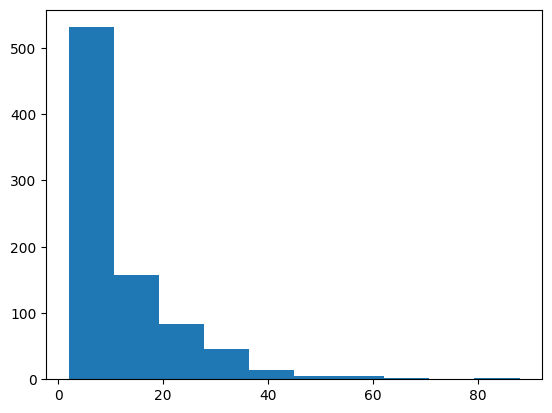

In [95]:
import matplotlib.pyplot as plt 

plt.hist(train_xs_ys.customer_id.apply(lambda x: hash(x) % 1350).value_counts())

In [99]:
train_xs_ys.customer_id.apply(lambda x: hash(x) % 1350).value_counts()[:20] 

customer_id
725     88
275     88
1230    76
1123    70
1046    68
1184    62
201     58
940     58
107     54
1209    54
941     50
1070    50
696     50
536     50
255     48
419     44
430     44
726     42
14      42
178     42
Name: count, dtype: int64

In [11]:
utoix, ixtou = {}, {}
for i, u in enumerate(train_xs_ys["customer_id"].unique()):
    utoix[u] = i
    ixtou[i] = u
    
atoix, ixtoa = {}, {}
for i, a in enumerate(train_xs_ys['article_id'].unique()):
    atoix[a] = i
    ixtoa[i] = a

# Training 

In [12]:
len(ixtou), len(atoix)

(1659, 2696)

In [13]:
embedding_size = 32

In [14]:
import torch

torch.Size([1350, 32])
torch.Size([3073, 32])


In [171]:
train_xs_ys = train_xs_ys.sample(frac=1, random_state=42)

In [15]:
xs, ys = train_xs_ys[['customer_id', 'article_id']], train_xs_ys[['label']]
xs['article_id'] = xs['article_id'].astype(int)
xs, ys = xs.to_numpy(), torch.tensor(ys.to_numpy())

/tmp/ipykernel_40/3353662721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xs['article_id'] = xs['article_id'].astype(int)


In [43]:
xs_test, ys_test = test_xs_ys[['customer_id', 'article_id']], test_xs_ys[['label']]
xs_test['article_id'] = xs_test['article_id'].astype(int)
xs_test, ys_test = xs_test.to_numpy(), torch.tensor(ys_test.to_numpy())

/tmp/ipykernel_40/1822066797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xs_test['article_id'] = xs_test['article_id'].astype(int)


In [90]:
W = torch.randn([64, 1], requires_grad=True)

num_users = len(utoix)
user_embeddings = torch.randn([num_users, embedding_size], requires_grad=True)


num_articles = len(atoix)
article_embeddings = torch.randn([num_articles, embedding_size], requires_grad=True)


In [80]:

batch_size = 1000
num_batches = len(xs) / batch_size - 1
num_batches_test = len(xs_test) / batch_size - 1
num_batches, num_batches_test

(9.0, 1.0)

In [94]:

batch_size = 500
num_batches = len(xs) / batch_size - 1

train_losses, test_losses = [], []

def forward(x, y):
    user_index = utoix[x[0]]
    article_index = atoix[x[1]]
    user_embedding = user_embeddings[user_index]
    article_embedding = article_embeddings[article_index]
    X = torch.concat([user_embedding, article_embedding])

    Y = X @ W 
    p = 1 / (1 + torch.exp(-Y)) # sigmoid 

    loss = -1 * (torch.log(1 - p)*(1 - y) + y*torch.log(p))
    return loss
    

for epoch in range(10):
    
    training_rows = len(xs)
    train_loss, test_loss = [], []13
    for batch in range(int(num_batches)):
        
        test_batch = batch % int(num_batches_test)
        for i, x in enumerate(xs_test[test_batch * batch_size :  (test_batch+1) * batch_size]):

            loss = forward(x, ys_test[i])
            if not loss.isnan() and loss < 100:
                test_loss.append(loss.item())
                
        for i, x in enumerate(xs[batch * batch_size :  (batch+1) * batch_size]):

            loss = forward(x, ys[i])

            if loss < 100:
                train_loss.append(loss.item())

                loss.backward()

                learning_rate = 0.01
                W.data -= learning_rate * W.grad
                user_embeddings.data -= learning_rate * user_embeddings.grad
                article_embeddings.data -= learning_rate * article_embeddings.grad

                W.grad.zero_()
                user_embeddings.grad.zero_()
                article_embeddings.grad.zero_()

        
                
        print(f"batch {batch}, train_loss: {sum(train_loss) / len(train_loss)}, test_loss: {sum(test_loss) / len(test_loss)}")
                
    train_loss = sum(train_loss) / len(train_loss)
    test_loss = sum(test_loss) / len(test_loss)
        
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"epoch {epoch}, train_loss: {train_loss}, test_loss: {test_loss}")

batch 0, train_loss: 0.7271561782062054, test_loss: 0.701307953774929
batch 1, train_loss: 0.7198209977671504, test_loss: 0.7297457435429097
batch 2, train_loss: 0.7138449220061303, test_loss: 0.7393641218096018
batch 3, train_loss: 0.7227411798611283, test_loss: 0.7448301489204169
batch 4, train_loss: 0.7265319814383984, test_loss: 0.7427540335953235
batch 5, train_loss: 0.7276069010595481, test_loss: 0.7421081892549991
batch 6, train_loss: 0.7265535507287298, test_loss: 0.7384855418886457
batch 7, train_loss: 0.7292616142909973, test_loss: 0.7389046436753124
batch 8, train_loss: 0.7319982317735751, test_loss: 0.7401963096939855
batch 9, train_loss: 0.7333144252702594, test_loss: 0.7382560744181276
batch 10, train_loss: 0.7333630560162393, test_loss: 0.7354161636707458
batch 11, train_loss: 0.734949713991334, test_loss: 0.7348127148685356
batch 12, train_loss: 0.7347663489660391, test_loss: 0.7333366251393006
batch 13, train_loss: 0.734556849421135, test_loss: 0.7325017400671329
batch

KeyboardInterrupt: 

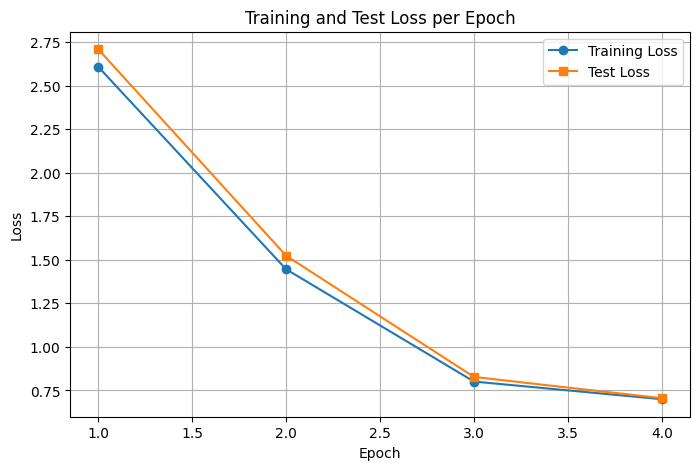

In [93]:
import matplotlib.pyplot as plt

# Assume train_losses and test_losses have been populated per epoch
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, test_losses, marker='s', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [95]:
W

tensor([[ 0.0850],
        [-0.0780],
        [-0.0036],
        [ 0.0180],
        [-0.0170],
        [-0.0469],
        [ 0.1032],
        [ 0.0181],
        [-0.0220],
        [-0.1256],
        [-0.1142],
        [-0.0169],
        [ 0.0376],
        [ 0.0834],
        [ 0.0225],
        [ 0.0947],
        [ 0.0347],
        [ 0.0807],
        [-0.0793],
        [ 0.0713],
        [-0.0753],
        [ 0.0671],
        [ 0.0004],
        [ 0.0912],
        [ 0.0329],
        [-0.0408],
        [ 0.0747],
        [-0.0271],
        [-0.0454],
        [ 0.1208],
        [ 0.1674],
        [-0.0462],
        [ 0.0144],
        [-0.0326],
        [-0.0413],
        [ 0.0248],
        [ 0.0786],
        [-0.0005],
        [-0.0245],
        [ 0.1237],
        [ 0.0214],
        [-0.0404],
        [-0.1036],
        [-0.0712],
        [ 0.0112],
        [-0.0376],
        [ 0.0400],
        [ 0.0054],
        [-0.0180],
        [-0.0644],
        [ 0.0113],
        [ 0.0213],
        [ 0.

In [215]:
user_embeddings

tensor([[ 0.3526,  0.5454, -1.3400,  ...,  1.1192,  0.5828, -0.4764],
        [-0.1501,  0.9552,  0.1456,  ..., -1.1566,  0.6688, -3.1323],
        [ 0.7509,  1.0891, -0.1447,  ..., -0.4954, -0.3704, -1.5541],
        ...,
        [-0.4991, -1.5514,  1.5965,  ...,  0.1483, -1.4015, -1.7373],
        [-1.5834,  1.3376,  0.2626,  ...,  0.1934,  0.6721,  0.5652],
        [ 2.0587,  0.6371,  1.2530,  ...,  1.2719, -0.5641,  1.1394]])

In [185]:
X = torch.concat([user_embedding, article_embedding])
X.shape

torch.Size([64])

In [193]:
W = torch.randn([64, 1])
W.shape

torch.Size([64, 1])

In [194]:

Y.shape

torch.Size([1])

In [205]:
-torch.log(probability)

tensor([1.0177])

In [241]:
2+2

4